# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [3]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'drive/My Drive/image_arrays_train.zip' .
!cp 'drive/My Drive/image_arrays_test.zip' .

cp: cannot stat 'drive/My Drive/image_arrays_train.zip': No such file or directory
cp: cannot stat 'drive/My Drive/image_arrays_test.zip': No such file or directory


In [4]:
# Extract
!unzip -q image_arrays_train.zip
!unzip -q image_arrays_test.zip

unzip:  cannot find or open image_arrays_train.zip, image_arrays_train.zip.zip or image_arrays_train.zip.ZIP.
unzip:  cannot find or open image_arrays_test.zip, image_arrays_test.zip.zip or image_arrays_test.zip.ZIP.


In [5]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

SampleSubmission.csv  Train.csv


In [6]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [17]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Remove all datapoints (images) that have a quality of 1 or less. Quality of 1 or less corresponds to a poor image.

In [19]:
train = train[train.Quality > 1]
print(train.shape)

(2552, 4)


Loading image_arrays_train/MH2O0YH.npy as an array
(360, 41, 41)
(41, 41)


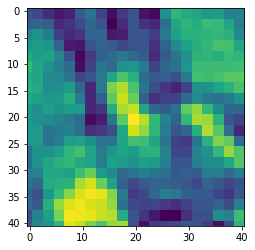

In [416]:
# Look at a sample:
# get a random sample from the dataset
#fid = train['Field_ID'].sample().values[0]
fid = train['Field_ID'].values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')

# load the randomly sampled datapoint image
arr = np.load(fn) # Loading the data with numpy
print(arr.shape)
#print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
#rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = arr[12]
print(rgb_jan.shape)
max_val = np.max(rgb_jan) 
if max_val == 0:
    max_val = 1
rgb_jan = rgb_jan / max_val # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

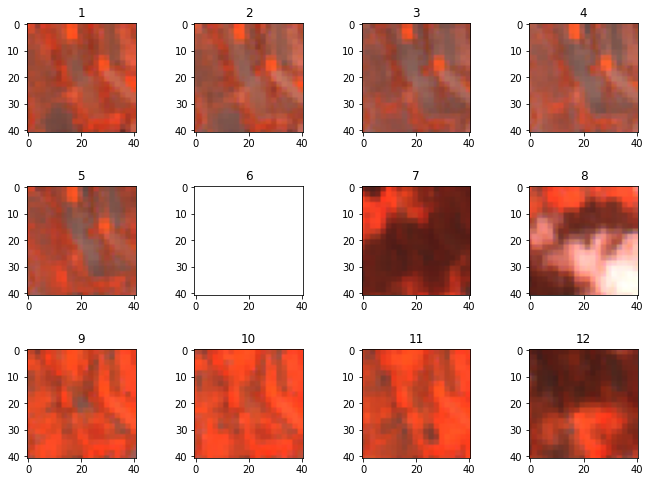

In [33]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

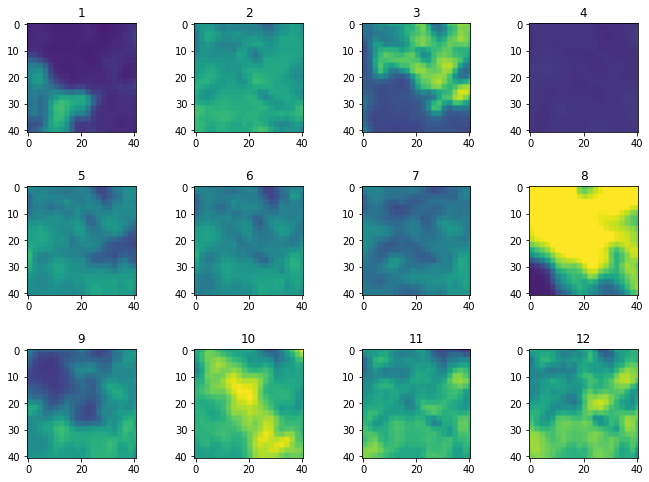

In [11]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

/home/t440p/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


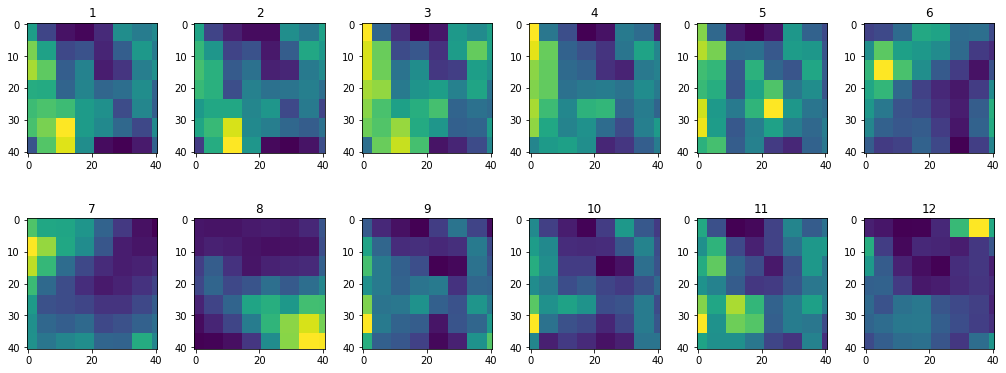

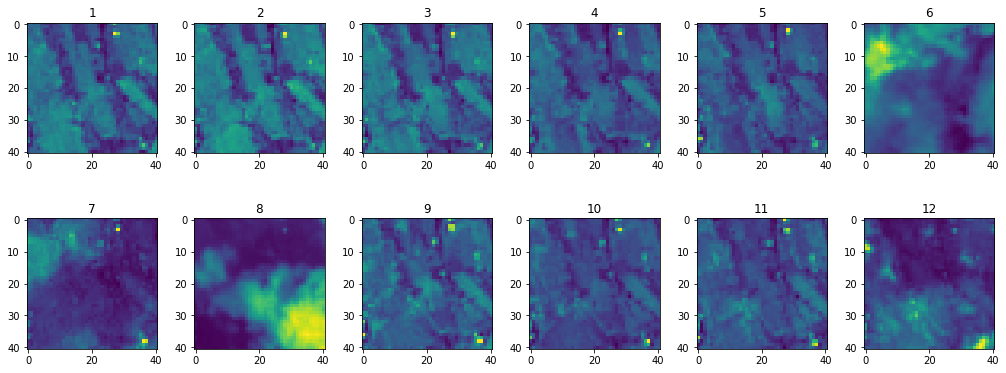

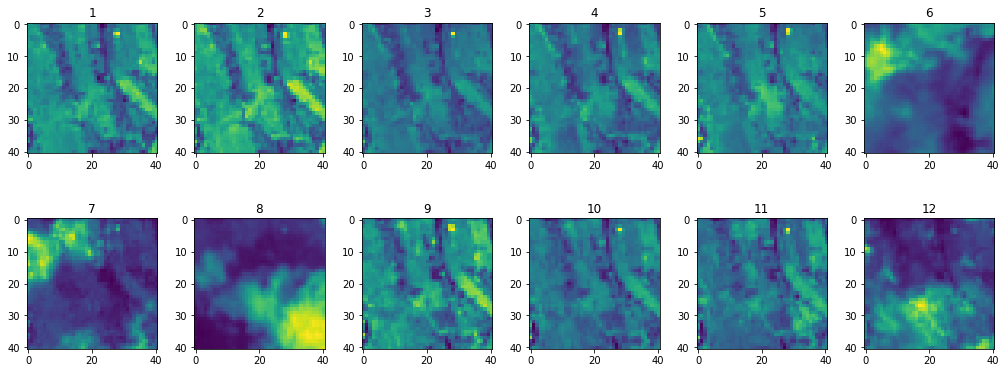

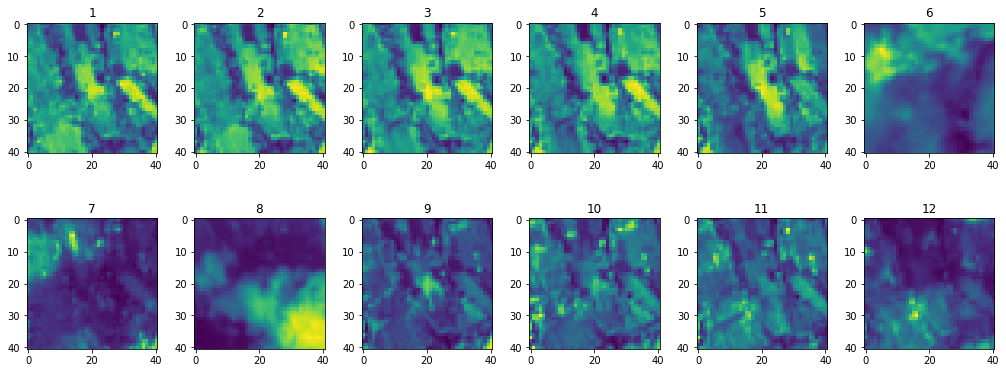

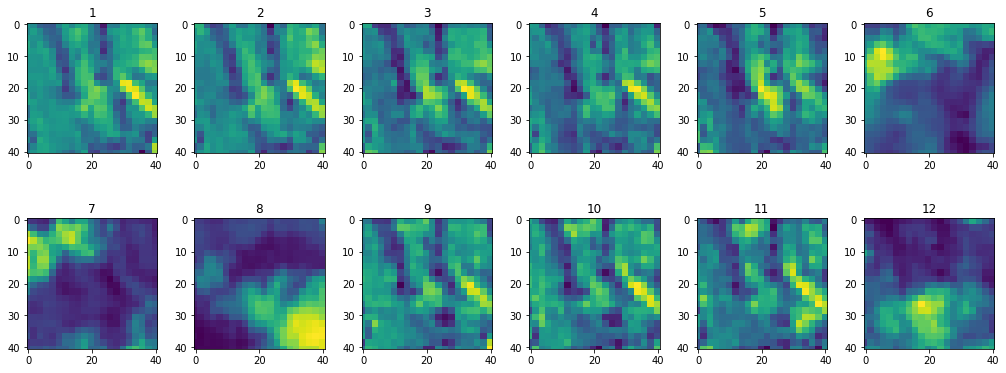

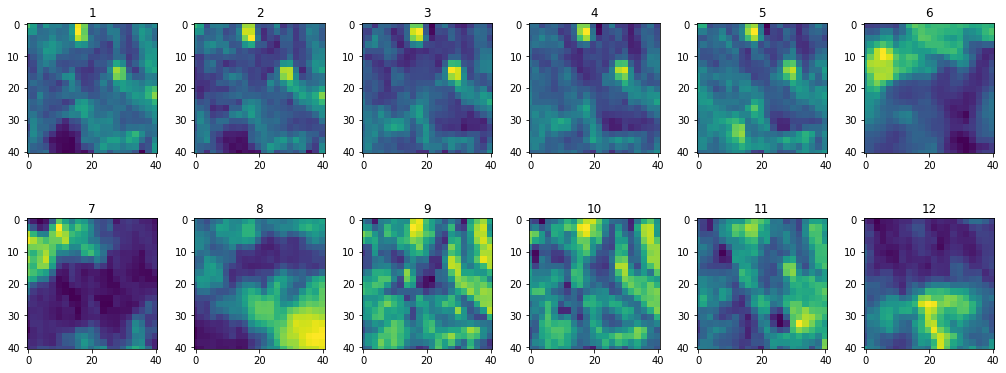

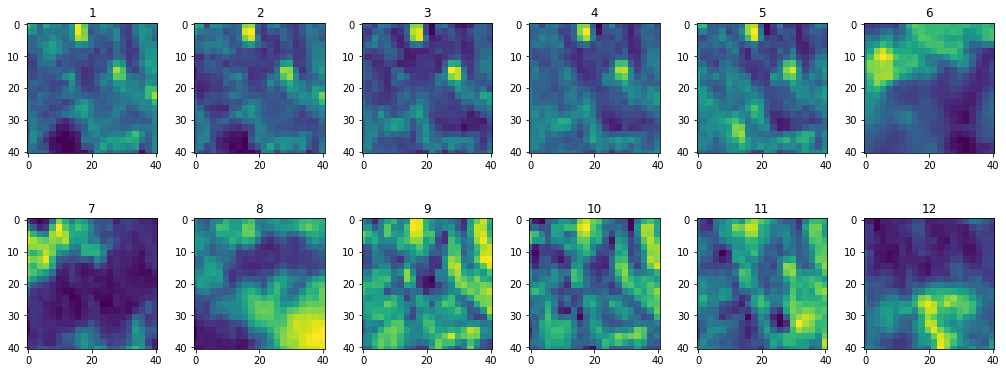

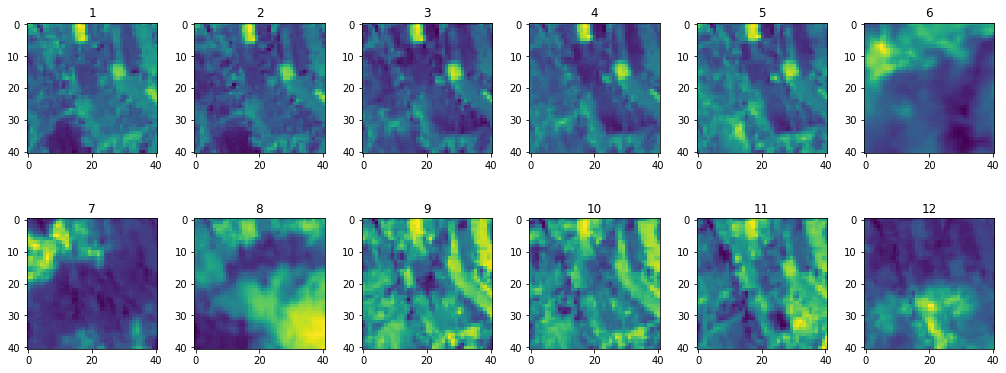

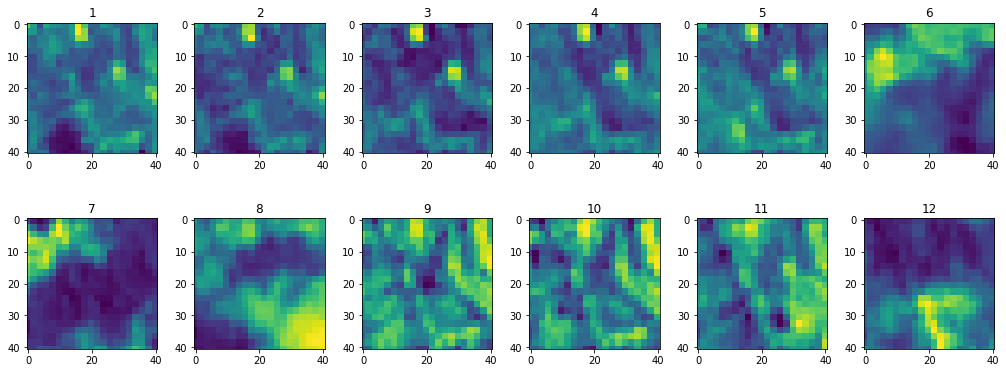

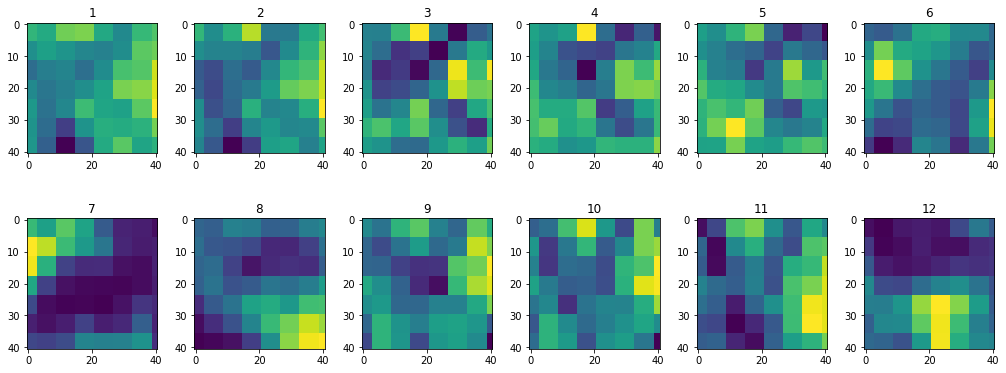

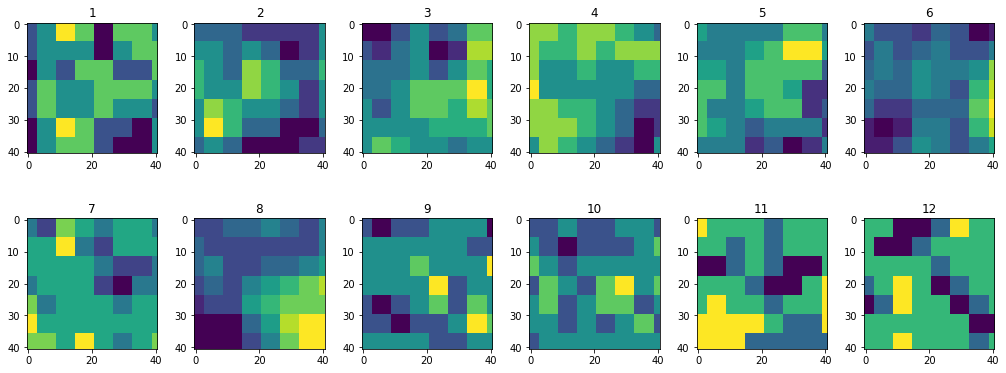

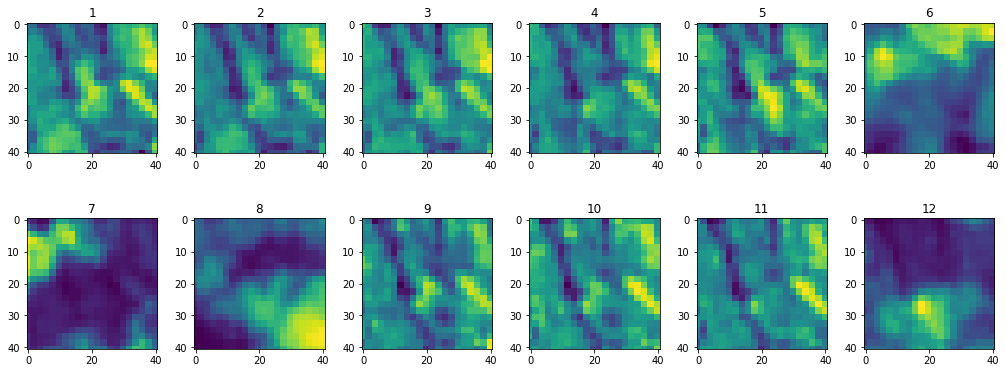

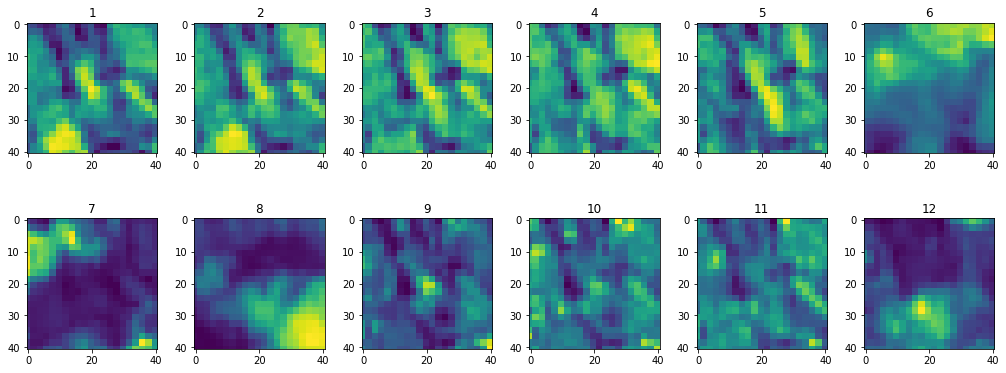

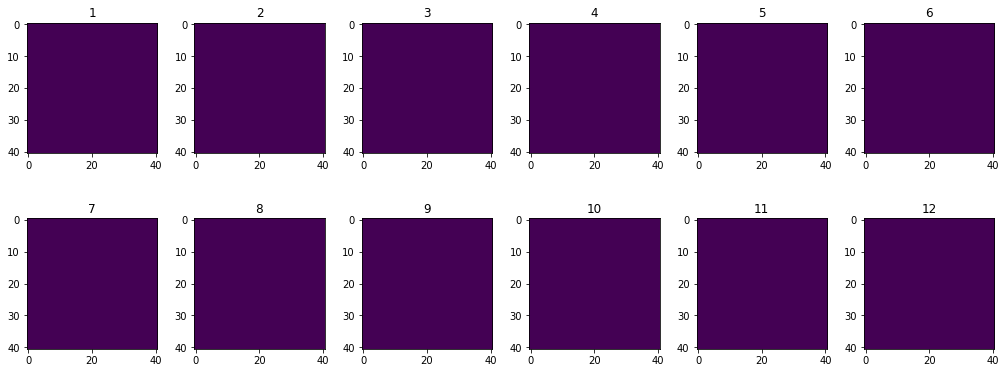

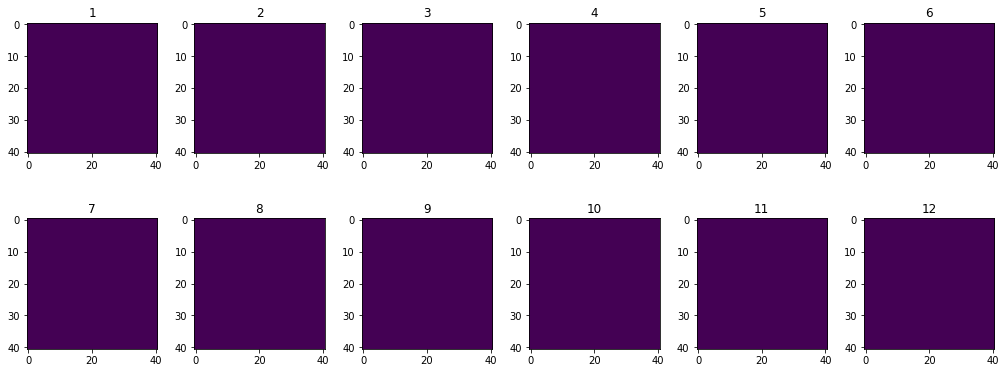

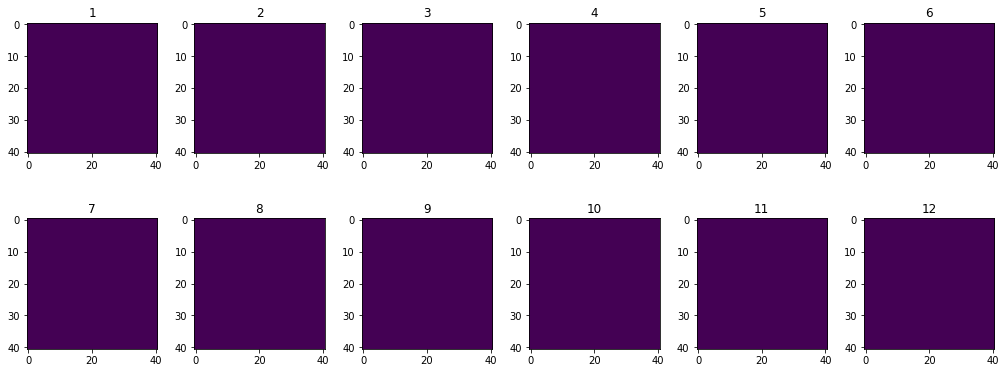

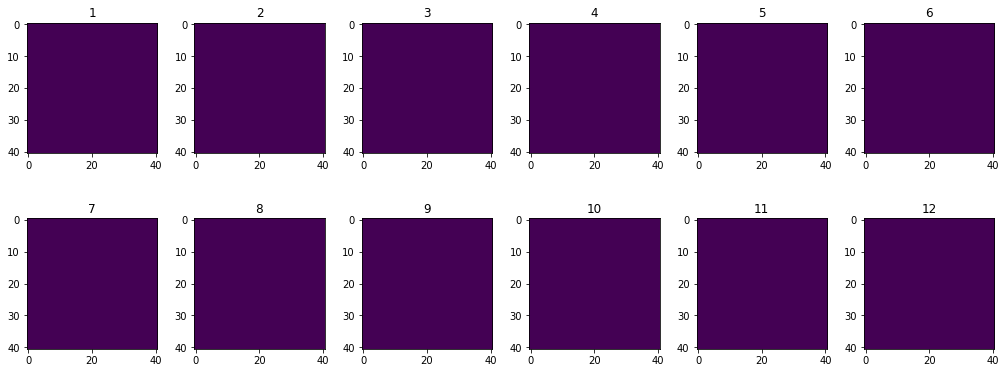

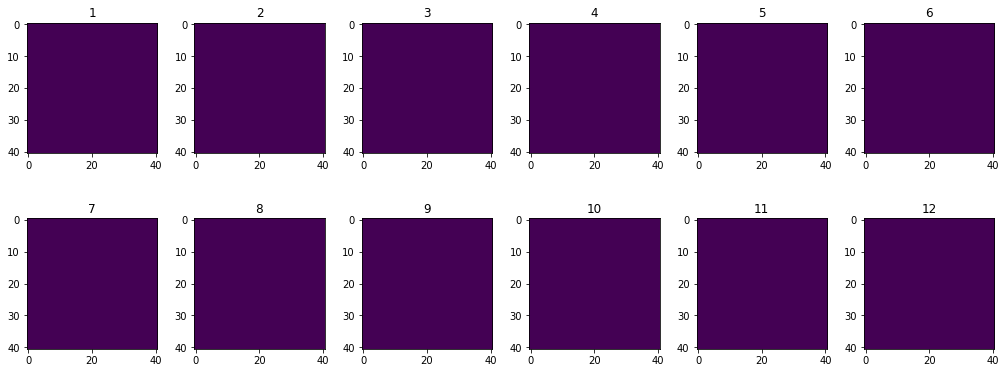

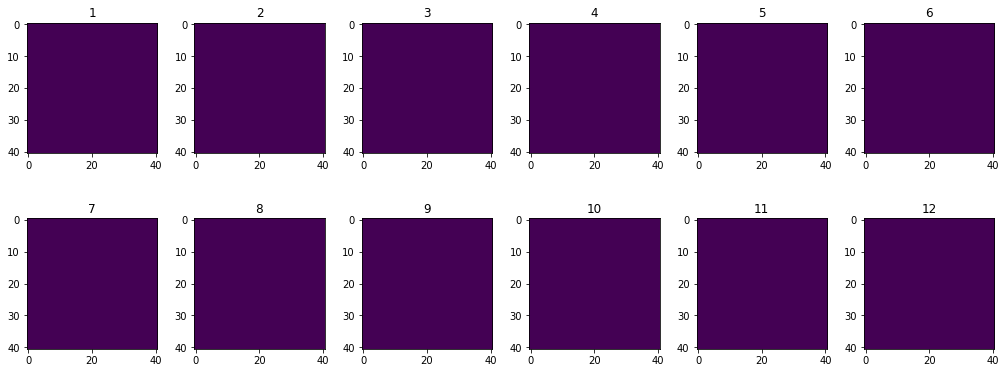

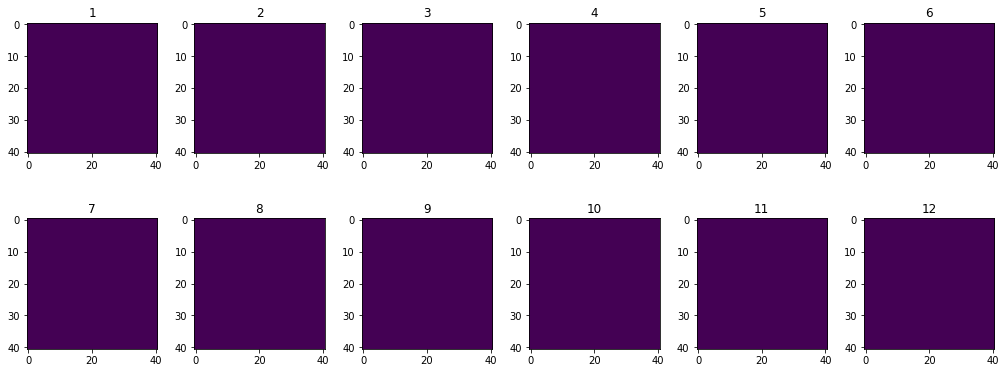

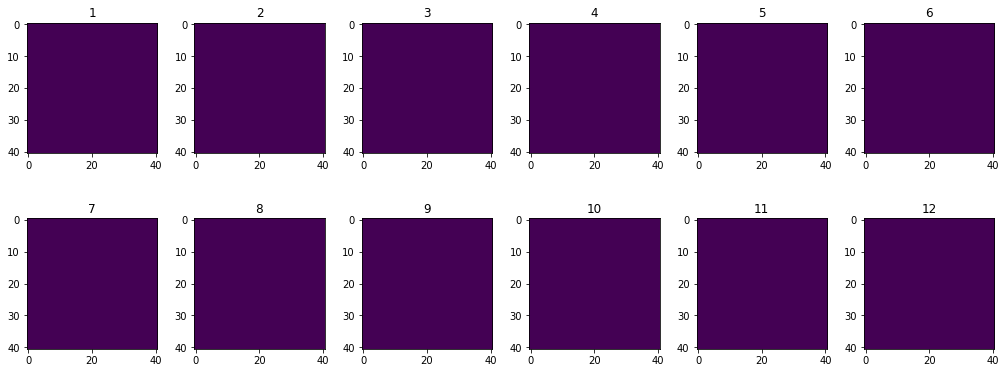

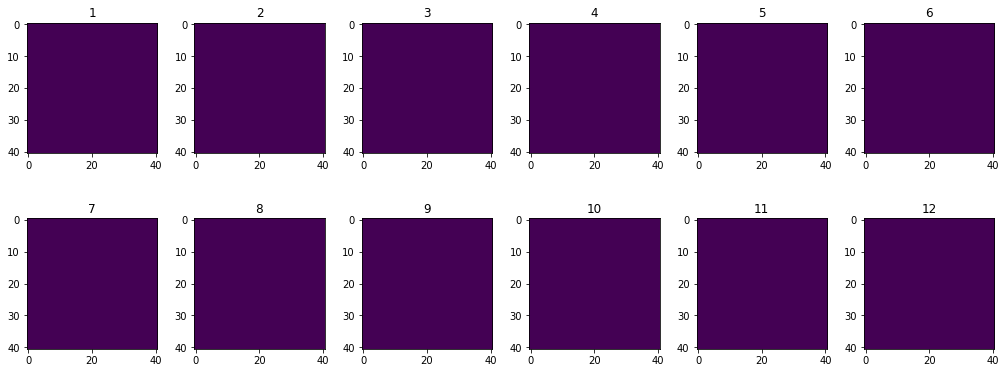

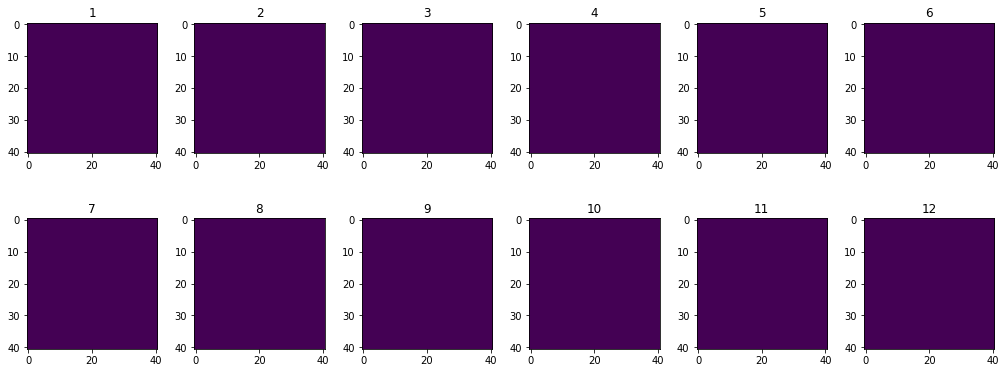

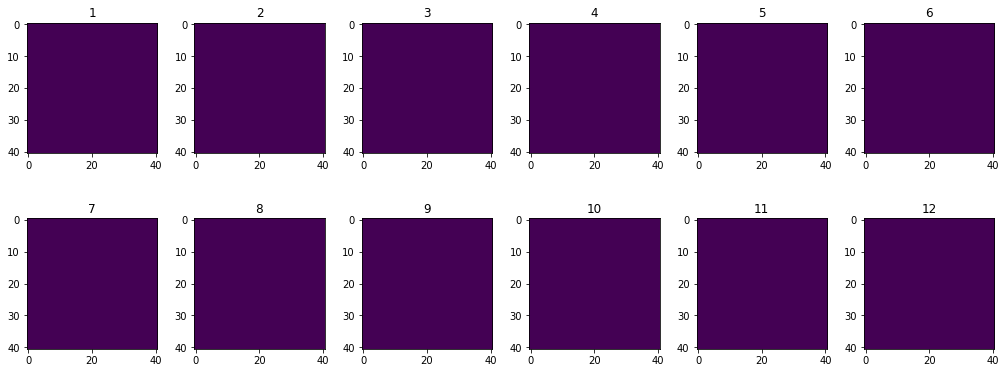

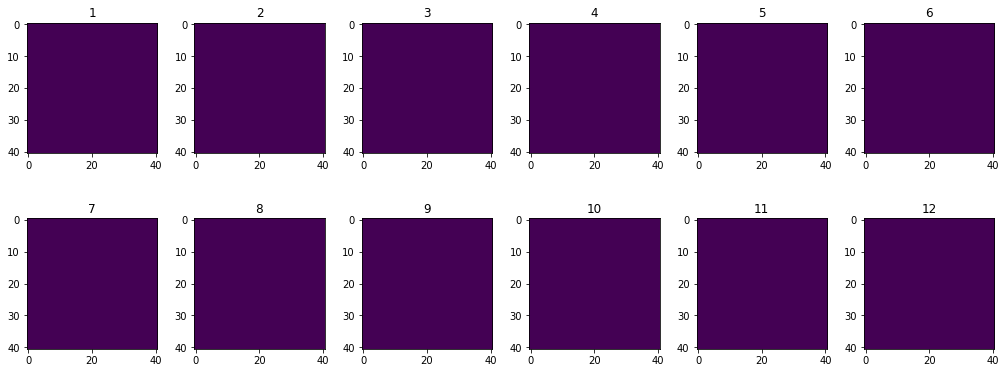

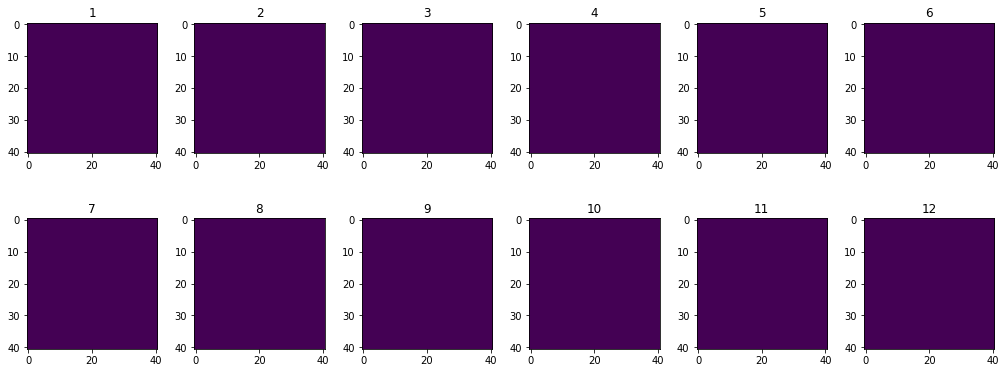

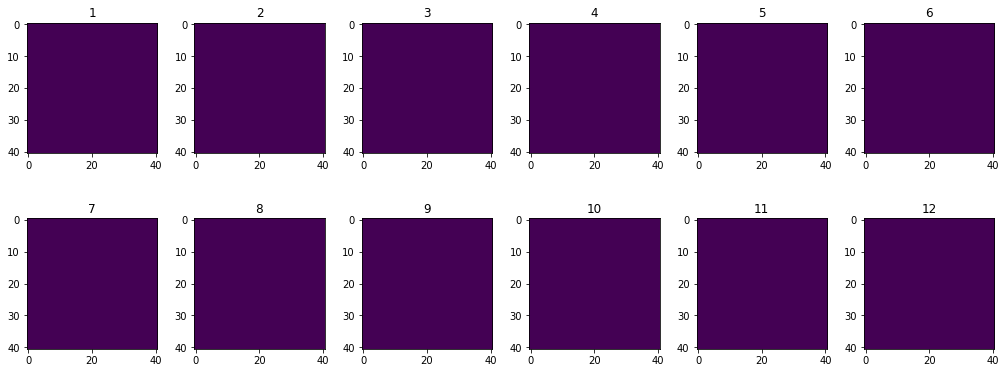

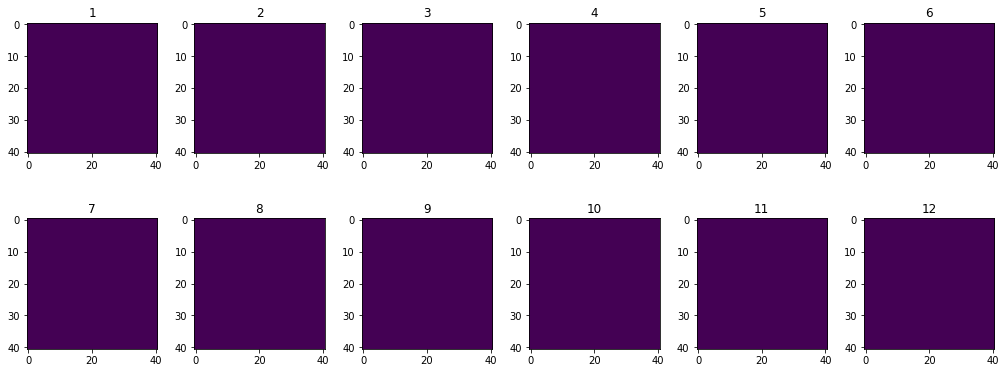

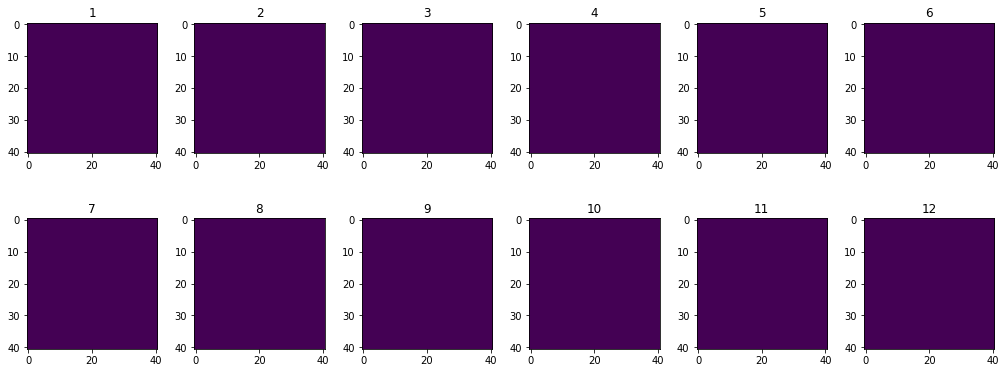

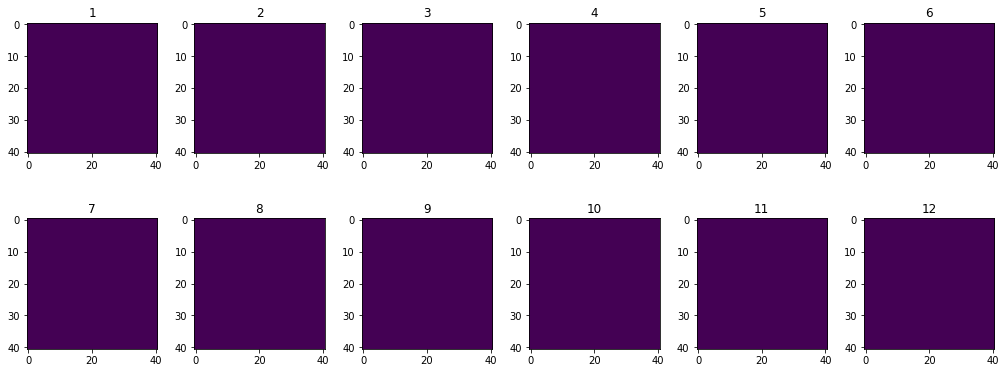

In [76]:
# look at all the months for each band
# Show the SWIR band (B12) where clouds have a high reflectance
for j in range(30):
    fig, axs = plt.subplots(2, 6, figsize=(18, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(12):
      image = arr[i*30 + j]
      axs[i].imshow(image)
      axs[i].set_title(str(i+1))
    

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [12]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

There are a couple ways to train. One way is to consider each image as an example, so that features of the examples are pixels. Each field ID has 360 images: 30 bands, with 12 images per band, corresponding to each month. Reduce features on this training model to find which pixels are most useful. Then once the most useful pixels are determined, change the dataset. Now, examples will be field IDs, where features are different bands in that field ID. The value of each feature will be a pixel value for that band. It is possible to have multiple pixels for a single band, all as different features for that example. 

Here is the training model to determine pixel worth. Each example is an image, with features as individual pixels. It is tested with one field ID at a time. The y value for an example image is the yield for the field ID that the image belongs to.

In [413]:
def get_image(fid, i):
    fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
    # load the randomly sampled datapoint image
    arr = np.load(fn) # Loading the data with numpy        
    return arr[i].flatten()[0:40**2]

import random
idxs = random.choices(range(train.shape[0]), k=50)
dfs = []
for j in idxs:
    # make a dataframe for the first field id
    df = pd.concat([pd.DataFrame([get_image(train['Field_ID'].values[j], i)]) for i in range(30)], ignore_index=True)
    field_id = []
    yield_vals = []
    for i in range(30):
        field_id.append(train['Field_ID'].values[j])
        yield_vals.append(train['Yield'].values[j])
    df['Field_ID'] = field_id 
    df['Yield'] = yield_vals
    dfs.append(df)

# combine the dataframes in dfs into a single df
df = pd.concat(dfs, ignore_index=True)
# shuffle the rows so that they're randomized
df.sample(frac=1)

,0,1,2,3,4,5,6,7,8,9,...,1592,1593,1594,1595,1596,1597,1598,1599,Field_ID,Yield
959,229,229,229,229,229,229,229,229,229,229,...,262,262,262,262,262,262,262,262,R3O8JO7,2.81900
689,320,320,320,320,320,320,320,320,320,320,...,320,320,320,320,320,320,320,320,C8UKBLX,4.00500
1029,687,687,722,722,722,722,722,722,675,675,...,677,677,677,677,717,717,717,657,ATSFG7V,1.75500
9,1405,1405,1405,1405,1405,1405,1399,1399,1399,1399,...,1461,1461,1461,1461,1432,1432,1432,1432,QI7XB4S,1.55625
1081,889,930,908,914,938,968,982,989,972,968,...,923,959,953,973,941,908,928,1019,D6OIFF1,2.60625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,578,578,578,578,578,578,578,578,578,578,...,578,578,578,578,578,578,578,578,52NLOWG,3.15100
19,1913,1913,1913,1913,1913,1913,1913,1913,1913,1913,...,1913,1913,1913,1913,1913,1913,1913,1913,QI7XB4S,1.55625
1239,1182,1182,1182,1182,1180,1180,1180,1180,1180,1180,...,779,779,779,779,779,779,1179,1154,LUEV50S,3.48125
1016,291,291,291,291,291,291,291,291,291,291,...,291,291,291,291,291,291,291,291,WKUB0CU,2.49200


Now train a model with the above dataset that is just images.

In [414]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split the data
X, y  = df[df.columns[:-2]], df['Yield']
X_train, y_train = X[0:int(np.floor(X.shape[0]*0.7))], y[0:int(np.floor(y.shape[0]*0.7))]
X_val, y_val = X[int(np.floor(X.shape[0]*0.7)):int(np.floor(X.shape[0]*0.9))], y[int(np.floor(y.shape[0]*0.7)):int(np.floor(y.shape[0]*0.9))]

print(X_train.shape)
print(X_val.shape)

# Fit the model
model = RandomForestRegressor(n_estimators=50, max_depth=8)
model.fit(X_train, y_train)
score = mean_squared_error(y_val, model.predict(X_val), squared=False)
print("Score: ", score)

(1050, 1600)
(300, 1600)
Score:  1.602410323609747


0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [339]:
def process_im(fid, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands = ['S2_B1', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'S2_B9', 'S2_B10', 'S2_B11', 'S2_B12', 'S2_QA10', 'S2_QA20', 'S2_QA60', 'CLIM_aet', 'CLIM_def', 'CLIM_pdsi', 'CLIM_pet', 'CLIM_pr', 'CLIM_ro', 'CLIM_soil', 'CLIM_srad', 'CLIM_swe', 'CLIM_tmmn', 'CLIM_tmmx', 'CLIM_vap', 'CLIM_vpd', 'CLIM_vs']
  bands_of_interest = [bands[0], bands[3], bands[8]]
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    # get the whole image in the form of an array
    vs = np.empty(idxs[0].size)
    i=0
    for idx in idxs[0]:
        vs[i] = arr[idx, 20, 20]
        i+=1
    #vs = arr[idxs, 20, 20]
    for bn, v in zip(bns, vs):
        values[bn] = v
  return values

# Example
process_im('35AFSDD')

{'0_S2_B1': 1095.0,
 '0_S2_B4': 1357.0,
 '0_S2_B8A': 2588.0,
 '1_S2_B1': 1152.0,
 '1_S2_B4': 1588.0,
 '1_S2_B8A': 2799.0,
 '2_S2_B1': 1098.0,
 '2_S2_B4': 1346.0,
 '2_S2_B8A': 1990.0,
 '3_S2_B1': 1218.0,
 '3_S2_B4': 1426.0,
 '3_S2_B8A': 2238.0,
 '4_S2_B1': 1154.0,
 '4_S2_B4': 1460.0,
 '4_S2_B8A': 2450.0,
 '5_S2_B1': 8266.0,
 '5_S2_B4': 8875.0,
 '5_S2_B8A': 9390.0,
 '6_S2_B1': 1113.0,
 '6_S2_B4': 491.0,
 '6_S2_B8A': 4879.0,
 '7_S2_B1': 1060.0,
 '7_S2_B4': 552.0,
 '7_S2_B8A': 3178.0,
 '8_S2_B1': 1025.0,
 '8_S2_B4': 764.0,
 '8_S2_B8A': 2985.0,
 '9_S2_B1': 990.0,
 '9_S2_B4': 796.0,
 '9_S2_B8A': 2780.0,
 '10_S2_B1': 1093.0,
 '10_S2_B4': 929.0,
 '10_S2_B8A': 3485.0,
 '11_S2_B1': 3438.0,
 '11_S2_B4': 3598.0,
 '11_S2_B8A': 5769.0}

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [340]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B1,0_S2_B4,0_S2_B8A,1_S2_B1,1_S2_B4,1_S2_B8A,2_S2_B1,2_S2_B4,2_S2_B8A,3_S2_B1,...,9_S2_B4,9_S2_B8A,10_S2_B1,10_S2_B4,10_S2_B8A,11_S2_B1,11_S2_B4,11_S2_B8A,Field_ID,Yield
0,1024.0,1173.0,2327.0,1074.0,1397.0,2413.0,1090.0,1518.0,2400.0,1180.0,...,903.0,3001.0,1017.0,690.0,2949.0,1000.0,393.0,2307.0,MH2O0YH,3.686
1,1023.0,924.0,2040.0,1079.0,1011.0,1936.0,1054.0,1020.0,1928.0,1862.0,...,817.0,2342.0,1025.0,512.0,4152.0,982.0,323.0,954.0,O9TURWL,5.657
2,1095.0,1357.0,2588.0,1152.0,1588.0,2799.0,1098.0,1346.0,1990.0,1218.0,...,796.0,2780.0,1093.0,929.0,3485.0,3438.0,3598.0,5769.0,35AFSDD,3.082
3,976.0,639.0,2921.0,994.0,823.0,2795.0,1033.0,916.0,2683.0,1101.0,...,581.0,3632.0,994.0,537.0,3451.0,6876.0,8025.0,9221.0,PM05EG9,2.707
4,1300.0,1162.0,2984.0,1254.0,1133.0,2379.0,1397.0,1542.0,3031.0,1220.0,...,694.0,3566.0,1253.0,657.0,3145.0,1352.0,789.0,3744.0,V7PZBCG,2.679


# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

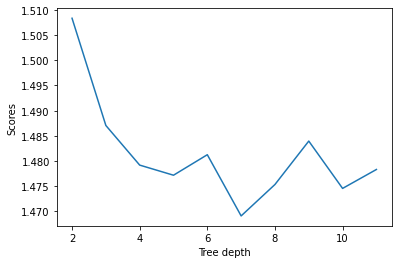

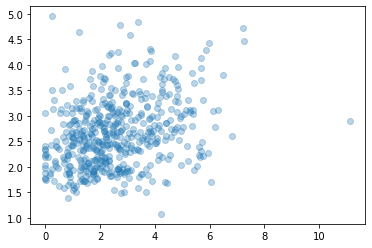

In [341]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split the data
X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']
#X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, y_train = X[0:int(np.floor(X.shape[0]*0.7))], y[0:int(np.floor(y.shape[0]*0.7))]
X_val, y_val = X[int(np.floor(X.shape[0]*0.7)):int(np.floor(X.shape[0]*0.9))], y[int(np.floor(y.shape[0]*0.7)):int(np.floor(y.shape[0]*0.9))]

# Fit the model
#model = RandomForestRegressor(n_estimators=200)
#model = AdaBoostRegressor(n_estimators=100)

# test the effect of max depth of the trees 
scores = []
for i in range(2, 12):
    intermediate_scores = []
    for j in range(3):
        # voting between multiple regressors
        reg1 = GradientBoostingRegressor(n_estimators=50, max_depth=i)
        reg2 = RandomForestRegressor(n_estimators=50, max_depth=i)
        reg3 = BaggingRegressor(n_estimators=50)
        # array storing all the models
        model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('br', reg3)])
        model.fit(X_train, y_train)
        intermediate_scores.append(mean_squared_error(y_val, model.predict(X_val), squared=False))
    # Score with RMSE
    scores.append(np.mean(intermediate_scores))
    
# plot the score against tree depth
plt.plot(range(2, 12), scores)
plt.ylabel('Scores')
plt.xlabel('Tree depth')
plt.show()
# Plot pred vs actual for the test set:
plt.scatter(y_val, model.predict(X_val), alpha=0.3)


In [342]:
print(min(scores))

1.4690097418582884


# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [62]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

# Get model predictions
preds = model.predict(test_sampled)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.375058
1,1WGGS1Q,3.304667
2,EG2KXE2,3.472369
3,HC3GQXF,3.573870
4,7AK6GFK,3.276695


You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
4.   We did no model tuning, so obviously lots of fun to be had there
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.
6.   ... As always, be creative - I'm sure there are lots more improvements to be made

